In [6]:
# coding: utf-8
import warnings
warnings.filterwarnings('ignore')
import time
import os
import numpy as np
import keras
from keras import metrics
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D,Activation
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers.embeddings import Embedding
from datetime import datetime
from gensim.models import word2vec
from collections import *
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def text_to_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word])
            except:
                new_doc.append(0)
#         new_doc_arr = np.array(new_doc).reshape(1, max_doc_word_length)
        new_doc_arr = np.array(new_doc)
        new_corpus.append( new_doc_arr)
    return np.array(new_corpus)

In [8]:
# get data
# get texts data
category2idx = {'AllTogether': 0, 'Baseball': 1, 'Boy-Girl': 2, 'C_chat':  3, 'CVS': 4,
                  'GameSale': 5, 'GetMarry': 6, 'Lifeismoney': 7, 'LoL': 8, 'MH': 9, 'MLB': 10, 'Mobilecomm': 11, 
                'movie': 12,'MuscleBeach':  13, 'NBA': 14,  'SENIORHIGH': 15, 'Stock': 16, 
                'Tennis': 17, 'Tos': 18, 'WomenTalk': 19}

train_df_sample = pd.read_pickle('train.pkl').sample(frac=1, random_state=123)
train_texts = train_df_sample.values
label_list = train_df_sample.label

test_pickle_df = pd.read_pickle('test.pkl')
test_texts = test_pickle_df["text"].values

train_texts_list = []
for text in train_texts:
    train_texts_list.append(text[0])
    
texts_list = []
for text in train_texts_list:
    texts_list.append(text)
    
for text in test_texts:
    texts_list.append(text)

In [9]:
# get word embedding vector
answer = word2vec.Word2Vec.load("word2vec_20180430.model")
word_vectors = answer.wv
wvv = word_vectors.vocab
wvv_keys = wvv.keys()
wvv_keys_list = list(wvv_keys)

vocab_num = len(wvv.items()) + 1

vocab_list = [(word, word_vectors[word]) for word, _ in wvv.items()]

In [10]:
del word_vectors, wvv, train_texts_list, answer

In [11]:
word_vec_len = 256
embedding_matrix = np.zeros((vocab_num , word_vec_len))
word2idx = {}

for i, vocab in enumerate(vocab_list):
    word, vec = vocab
    embedding_matrix[i + 1] = vec
    word2idx[word] = i + 1

In [12]:
embedding_matrix.shape

(87784, 256)

In [7]:
embedding_layer = Embedding( input_dim= embedding_matrix.shape[0],output_dim= 256, weights=[embedding_matrix], 
                            input_length = 200,trainable=False)
# model = getModel(embedding_layer, image_width, image_height, input_channel)
model = Sequential()
model.add(embedding_layer )
model.add(Conv1D(256, 3,padding = 'same', ))
model.add(Flatten())
model.add(Dense(2, activation='relu'))
model.compile(optimizer='adam',loss='mae')
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 256)          22472704  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 256)          196864    
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102402    
Total params: 22,771,970
Trainable params: 299,266
Non-trainable params: 22,472,704
_________________________________________________________________


In [8]:
max_doc_word_length = 200

x_trains_texts = train_df_sample.text.append(test_pickle_df.text)
X_train_texts = text_to_index(x_trains_texts)
X_train = pad_sequences(X_train_texts, maxlen= max_doc_word_length)

Y_label_list = np.zeros((36000, 2))
for ids in range(0, 36000):
    Y_label_list[ids][0] = label_list[ids][0]
    Y_label_list[ids][1] = label_list[ids][1]
print(Y_label_list.shape)

(36000, 2)


In [9]:
history = model.fit(x = X_train[0:36000], 
                    y = Y_label_list, 
                    batch_size= 10000,
                    epochs = 60, verbose = 1)

Epoch 1/60
36000/36000 [==============================] - 688s 19ms/step - loss: 12.1236
Epoch 2/60
10000/36000 [=======>......................] - ETA: 10:03 - loss: 11.6164

KeyboardInterrupt: 

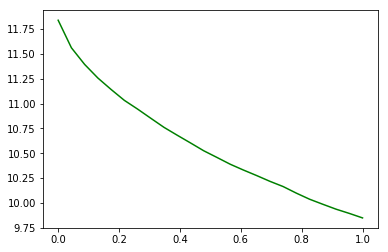

In [5]:
# np_loss_history = np.array(history.history['loss'])
# np.savetxt("loss_history.txt", np_loss_history, delimiter=",")
loss_history = np.loadtxt("loss_history.txt")
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 1, loss_history.shape[0])

plt.plot(x, loss_history, '-g');  # dotted red


In [ ]:
model.save('my_model.h5') 

In [ ]:
# evaluate the model
loss_accuracy = model.evaluate(X_train[0:100], Y_label_list[0:100], verbose=1)
print(type(loss_accuracy), loss_accuracy)

test_sequences1 = X_train[36000:40000]

predict_res = model.predict(test_sequences1, batch_size= 3600, verbose=0)

final_res = []
for pre_res in predict_res:
    final_res.append(pre_res)
# print(final_res)

In [ ]:
print(predict_res[0])

In [ ]:
# result_txt = "result" + str(datetime.now()).split()[1] + ".txt"
print(len(final_res))
result_txt = "local_result001" + ".txt"
ids = 0
with open(result_txt, 'w') as out:
    out.write("id,good,bad" + '\n')
    for value in final_res:
        out.write(str(ids) + "," + str(int (round(value[0]))) + "," + str(int (round(value[0]))) + '\n')
        ids += 1